In [23]:
import plotly.express as px
from matplotlib.pyplot import figure


<Figure size 7200x4800 with 0 Axes>

<Figure size 7200x4800 with 0 Axes>

In [3]:
import os
import pandas as pd
import pickle
import numpy as np

In [2]:
import scipy.spatial
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram 

In [4]:
def find_similar(search_name,matrix,num):
    name = [name for name, hangle_party in name_party_dict.items() if hangle_party[0] == search_name][0]
    tmp = matrix.loc[name]
    close = tmp.sort_values()[:num]
    unclose = tmp.sort_values()[-num:]
    close = list(map(lambda x : name_party_dict[x], close.index))
    unclose = list(map(lambda x : name_party_dict[x], unclose.index))

    return close, unclose

In [5]:
# 비유사도 측정 및 거리행렬 
with open('data\matrix.pickle', 'rb') as f:
    matrix = pickle.load(f)

In [6]:
with open('data\dict.pickle', 'rb') as f:
    name_party_dict = pickle.load(f)

In [7]:
distanceMatrix  = scipy.spatial.distance.pdist(matrix ,metric = 'cosine')
distanceMatrix  = scipy.spatial.distance.squareform(distanceMatrix)

In [8]:
distanceMatrixDf =  pd.DataFrame(distanceMatrix)

In [9]:
distanceMatrixDf.columns = matrix.columns
distanceMatrixDf.index = matrix.index

In [10]:
close, unclose = find_similar('양향자',distanceMatrixDf,40)

In [11]:
#%% 클러스터링. 
ac = AgglomerativeClustering(n_clusters = 2,  linkage='average')
labels = ac.fit_predict(distanceMatrixDf)
party = list(map(lambda x : name_party_dict[x][1], matrix.columns))
name = list(map(lambda x : name_party_dict[x][0], matrix.columns))

df = pd.DataFrame({'cluster': labels, 'party':party, 'name':name, 'hanja': matrix.columns})

colors = {'국민의힘':'red', '더불어민주당':'blue','한국의희망':'orange',
          '정의당':'yellow','무소속':'gray','시대전환':'purple','진보당':'green','기본소득당':'skyblue'}
df['color'] = [ colors[x] for x in df.party]

C:\Users\DongKeon\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:566: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



<ipython-input-11-815723dcb09d>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distanceMatrixDf, 'average')


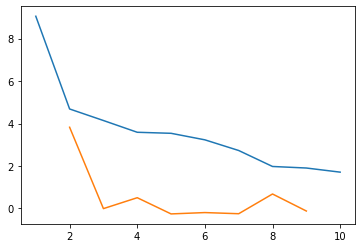

clusters: 2


In [11]:
#%% K-elbow
Z = linkage(distanceMatrixDf, 'average')

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)


In [12]:
#%% 시각화. 
## mds
matrix_embedded = MDS(n_components=2,random_state=1, eps = 0).fit_transform(distanceMatrixDf)
matrix_embedded = pd.DataFrame(matrix_embedded, columns = ['x1','x2'])
matrix_embedded['party'] = df['party']
matrix_embedded['cluster'] = df['cluster']

C:\Users\DongKeon\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.

C:\Users\DongKeon\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



In [ ]:
matrix_embedded['name'] = df['name']

In [29]:
matrix_embedded['color'] = [colors[x] for x in matrix_embedded['party']]

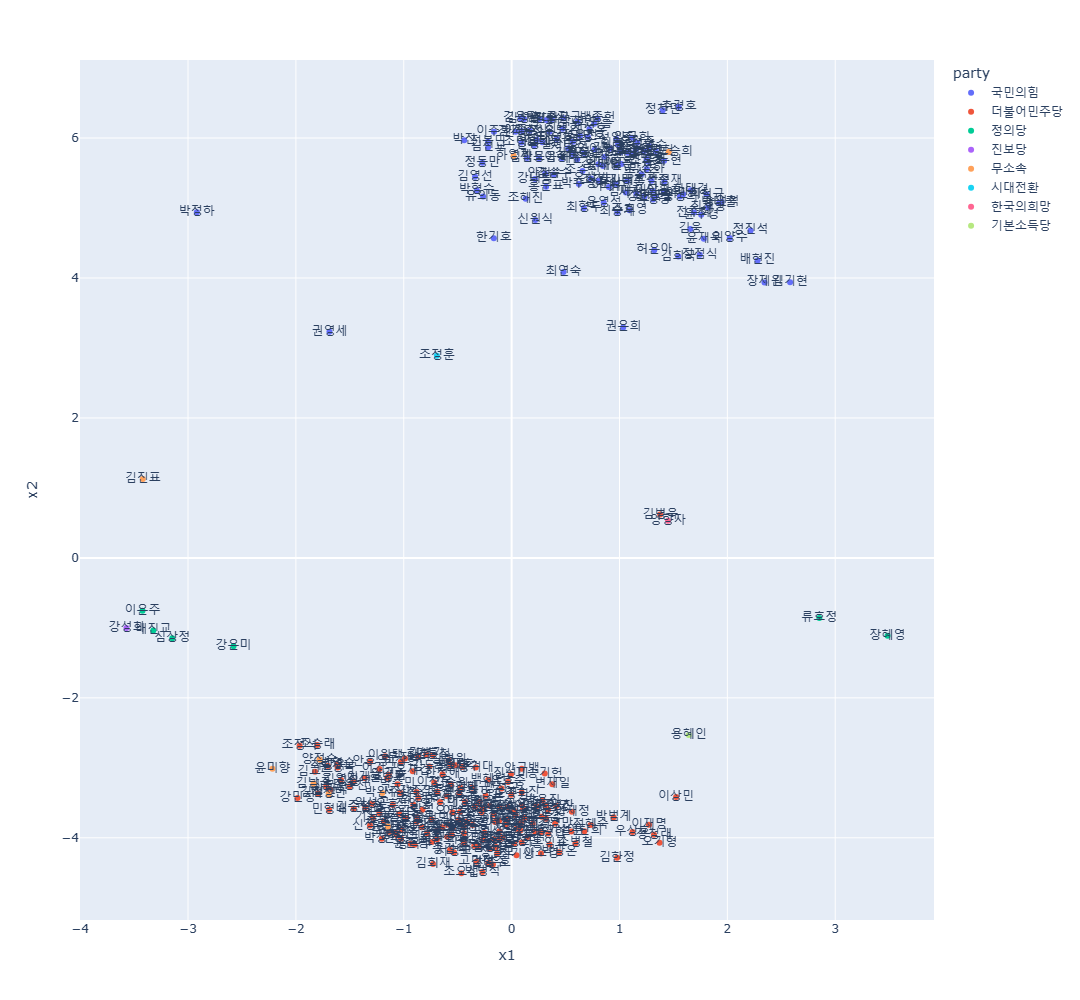

In [35]:
fig = px.scatter(matrix_embedded, x="x1", y="x2", color="party", text = 'name',width=1000, height=1000)
fig.show()

In [ ]:
sns.scatterplot(x = 'x1' , y = 'x2', data = matrix_embedded, hue = 'cluster',palette="Set1")

In [ ]:
## 덴도 그램

leaf_colors = dict(zip(df.name,df.color))

plt.rcParams["figure.figsize"] = (50,30)
dend = dendrogram(linkage(distanceMatrix, method='average'), 
     color_threshold=4, 
     leaf_font_size=9, 
     labels = df.name.tolist())

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

plt.show()

In [ ]:
# barchart

bar = df.groupby(['cluster']).party.value_counts().unstack('cluster').fillna(0)
bar = bar / bar.sum(axis=0)
bar = bar.T

plt.rcParams["figure.figsize"] = (10,10)
bar.plot(kind='bar', stacked=True, color=[colors.get(x, '#333333') for x in bar.columns])

In [36]:
# 핵심 인물 찾기

In [37]:
# 가장 법률 발의 패턴이 비슷한 순위, 가장 많이 만든 순위

In [38]:
# 시간순으로 (축고정이 이슈일듯)